# Problem Set 5: Profit Diagram and Breakeven Points for a Short Strangle
A short strangle is an [advanced trading strategy](https://www.tastylive.com/concepts-strategies/strangle) that involves selling both a call and a put option on the same underlying stock. In this strategy, both options have the same expiration date but different strike prices. 

## Learning tasks
This example will help students learn how to compute profit, breakeven points, the probabilities of downside and upside loss, and the probability of achieving maximum profit for short strangles at expiration.
* __Prerequisites__: load the option chain data for `62-DTE` contracts on [Micron Technology](https://www.micron.com/about), which has the ticker symbol `MU.` We'll use this data for our analysis.
*  __Task 1__: Select the strike prices for the short strangle trade's `call` and `put` legs randomly from the `MU` options chain data.
*  __Task 2__: Build contract models for the short `call` and `put` contract legs and compute the payoff, profit, and breakeven values for the `MU` short strangle.
*  __Task 3__: Compute the probability of observing various scenarios for the `MU` short strangle positions. 

## Setup
Set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [19]:
import Pkg; Pkg.add("Colors")
include("Include.jl");


   Resolving package versions...
    Updating `~/Documents/GitHub/PS5-CHEME-5660-TEMPLATE-Fall-2024/Project.toml`
  [5ae59095] + Colors v0.13.0
  No Changes to `~/Documents/GitHub/PS5-CHEME-5660-TEMPLATE-Fall-2024/Manifest.toml`


## Prerequisites
We'll build our short strangle using options chain data for `62-DTE` contracts on [Micron Technology](https://www.micron.com/about), which has the ticker symbol `MU.` 
* Load the options chain dataset by calling the `MyOptionsChainDataSet()` function, which returns the pricing data as a `DataFrame` instance, which is exported by the [DataFrames.jl package](https://github.com/JuliaData/DataFrames.jl). Let's save the options data in the `dataset::DataFrame` variable:

In [20]:
dataset = MyOptionsChainDataSet()

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,Delta,IV,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,32.5,0.5912,46.9,47.22,47.55,49.16,0,2,0.99881,0.6458,Call
2,35.0,0.5597,44.4,44.8,45.2,39.75,0,1,0.99364,0.8463,Call
3,37.5,0.5283,41.95,42.33,42.7,0.0,0,0,0.99303,0.784,Call
4,40.0,0.4969,39.5,39.9,40.3,46.57,0,24,0.98822,0.7904,Call
5,42.5,0.4654,36.9,37.35,37.8,43.15,0,1,0.99424,0.6253,Call
6,45.0,0.434,34.55,34.88,35.2,37.85,0,27,0.9936,0.5769,Call
7,47.5,0.4025,32.15,32.5,32.85,30.35,0,85,0.98231,0.6363,Call
8,50.0,0.3711,29.65,30.03,30.4,30.35,2,65,0.95655,0.7286,Call
9,55.0,0.3082,24.85,25.2,25.55,25.69,30,377,0.96381,0.5384,Call


Set some constant values that we'll use in the subsequent calculation. See the comment next to the value for a description of what it is, its permissible values, etc.

In [21]:
DTE = 62.0; # days to expiration
Sₒ = 79.50; # MU underlying share price USD/share
Δt = (1/365); # Time step 1-trading day
risk_free_rate = 0.0431; # yield 10-year treasury note on 13-Jun-2024
h = 366; # 6-points per day
w = 0.3; # width parameter

## Task 1: Select the strike prices for the `call` and `put` legs of the strangle
In this task, we'll select random put and call contracts (from which we construct our strangle) from the `MU` options chain data.
Let the `put` leg of the stangle have index `1`, and the `call` leg have index `2`. 
* __Setup__: For our short strangle, the strike price of the `put` leg $K_{1}$ will be less than the strike price of the `call` leg $K_{2}$ and the initial share price $S_{\circ}$. On the other hand, the strike price of the `call` leg $K_{2}$ will be greater than the initial share price $S_{\circ}$. Thus, the `put` and `call` legs will bracket the initial share price, i.e., $K_{1}<S_{\circ}<K_{2}$. Let's select random strike prices for the `put` and `call` legs such that the $K_{1}<S_{\circ}<K_{2}$ inequality is true.

Starting with the `put` contracts, filter the `dataset` to find the `put` contracts such that $\left(1-w\right)\cdot{S}_{\circ}\leq{K_{1}}<S_{\circ}$, where the $w>0$-value is specified above. This will give `put` contracts with strikes less than the initial share price but not too far away from the money.

To do this, we'll use the [filter function](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter) exported by the [DataFrames.jl package](https://github.com/JuliaData/DataFrames.jl) in combination with the [Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). Save the filtered selection of `put` contracts in the `put_contracts::DataFrame` variable:

In [22]:
put_contracts = filter(:Type=>x->x == "Put", dataset) |> y -> filter(:Strike=> x-> (x < Sₒ && x ≥ (1-w)*Sₒ), y)

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,Delta,IV,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,57.5,-0.2767,0.28,0.3,0.31,0.3,25,"1,084",-0.04209,0.4954,Put
2,60.0,-0.2453,0.38,0.4,0.42,0.4,27,"2,485",-0.05638,0.4712,Put
3,62.5,-0.2138,0.55,0.57,0.58,0.52,1,"4,261",-0.07795,0.4545,Put
4,65.0,-0.1824,0.74,0.78,0.81,0.78,2,"2,156",-0.10551,0.4368,Put
5,67.5,-0.1509,1.07,1.1,1.13,1.13,23,"1,324",-0.14498,0.428,Put
6,70.0,-0.1195,1.53,1.56,1.58,1.62,614,"4,069",-0.19147,0.4149,Put
7,72.5,-0.0881,2.13,2.16,2.18,2.21,865,"2,992",-0.24963,0.407,Put
8,75.0,-0.0566,2.9,2.93,2.96,2.97,559,"3,034",-0.31662,0.4005,Put
9,77.5,-0.0252,3.85,3.9,3.95,4.0,456,"4,873",-0.39082,0.3954,Put


Select a random contract from the `put_contracts` collection; this will be our first leg of the strangle. Save the data for this contract in the `put_leg_data` variable, which is type [DataFrameRow](https://dataframes.juliadata.org/stable/lib/types/#DataFrames.DataFrameRow):

In [23]:
put_leg_data = nrow(put_contracts) |> i-> put_contracts[rand(1:i),:] # fancy!

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,Delta,IV,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
7,72.5,-0.0881,2.13,2.16,2.18,2.21,865,"2,992",-0.24963,0.407,Put


Next, do the same procedure for the `call` contracts. Filter `dataset` to find the `call` contracts with the property $S_{\circ}<K_{2}\leq\left(1+w\right)\cdot{S}_{\circ}$ where $w>0$ is specified above. To do this, we'll use the [filter function](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter) exported by the [DataFrames.jl package](https://github.com/JuliaData/DataFrames.jl) in combination with the [Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping).

Save the filtered selection of `call` contracts in the `call_contracts::DataFrame` variable:

In [24]:
call_contracts = filter(:Type=>x->x == "Call", dataset) |> y -> filter(:Strike=> x-> (x > Sₒ && x ≤ (1+w)*Sₒ), y)

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,Delta,IV,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,80.0,-0.0063,5.15,5.2,5.25,5.21,827,"4,243",0.53687,0.3935,Call
2,82.5,-0.0377,4.05,4.1,4.15,4.11,573,"5,190",0.4609,0.3918,Call
3,85.0,-0.0692,3.1,3.15,3.2,3.15,"22,430","23,281",0.38647,0.3869,Call
4,87.5,-0.1006,2.41,2.44,2.46,2.4,"1,183","9,508",0.31992,0.3883,Call
5,90.0,-0.1321,1.84,1.87,1.89,1.89,"2,868","9,954",0.26252,0.3923,Call
6,92.5,-0.1635,1.41,1.43,1.45,1.44,"5,563","9,912",0.21183,0.3943,Call
7,95.0,-0.195,1.07,1.12,1.16,1.16,103,"7,270",0.17495,0.4049,Call
8,97.5,-0.2264,0.82,0.85,0.88,0.9,41,391,0.13641,0.4029,Call
9,100.0,-0.2579,0.64,0.66,0.68,0.68,702,"10,624",0.11153,0.4118,Call


Select a random contract from the `call_contracts::DataFrames` collection; this will be our second leg of the strangle. Save the data for this contract in the `call_leg_data` variable, which is type [DataFrameRow](https://dataframes.juliadata.org/stable/lib/types/#DataFrames.DataFrameRow):

In [25]:
call_leg_data = nrow(call_contracts) |> i-> call_contracts[rand(1:i),:] # fancy!

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,Delta,IV,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,80.0,-0.0063,5.15,5.2,5.25,5.21,827,"4,243",0.53687,0.3935,Call


## Task 2: Build contract models and compute the profit and breakeven values at expiration
In this task, let's compute the profit and breakeven values for our short strangle position constructed from the two random contracts selected in Task 1.
Now that we have data for the contracts, we can compute the composite contract profit and breakeven values for the short strangle constructed from the randomly selected `put` and `call` legs.

* First, [create `MyAmericanPutContractModel` and `MyAmericanCallContractModel` models](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#American-option-contracts), initialized using the data from the random contracts from `Task 1`. Then, these contract models and possible share prices at expiration are passed to [the `payoff(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.payoff), which computes the individual and composite payoff and profit values.

Start with the `put` contract model. Build a [`MyAmericanPutContractModel instance`](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanPutContractModel) using the `put` contract data, and store this contract model in the `put_contract_model::MyAmericanPutContractModel` variable. 
* To access data from the `DataFrameRow,` pass in the column name. For example, to get the strike price, you would say: `put_leg_data[:Strike].` For the premium value, use the midpoint value.

In [27]:
put_contract_model = build(MyAmericanPutContractModel, (
        K = put_leg_data[:Strike], # TODO: set the strike price
        premium = put_leg_data[:Mid], # TODO: set the premium value
        sense = -1, # we are short, i.e., we *sold* this contract so sense = -1 
        copy = 1));

Similarly, construct the call contract model. Save the call contract model in the `call_contract_model::MyAmericanCallContractModel` variable:

In [28]:
call_contract_model = build(MyAmericanCallContractModel, (
        K = call_leg_data[:Strike], # TODO: set the strike price
        premium = call_leg_data[:Mid], # TODO: set the premium value
        sense = -1, # we are short, i.e., we *sold* this contract so sense = -1 
        copy = 1));

Next, create an array of values for the share price at expiration. We'll look at a range starting from below $K_{1}$ and ending above $K_{2}$ with `number_of_steps` values. Store these values in the `share_price_array::Array{Float64,1}` variable.

In [29]:
share_price_array = let

    w = 0.5; # width of range to explore. Adjust me to see what happens
    number_of_steps = 1001; # leave me alone!

    # build a range, then pass that to collect (which gives an array)
    share_price_array = range((1-w)*put_contract_model.K,stop = (1+w)*call_contract_model.K, length = number_of_steps) |> collect;

    # return the data
    share_price_array;
end;

Finally, compute the profit for the short strangle. We compute the profit by [calling the `profit(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.profit) and save the profit values in the `profit_array` variable. The [`profit(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.profit) takes two arguments, the contract models as an array and the share price array.

* The `profit_array` will be a `1001`$\times$ `4` array, in which each row is a possible value for the share price at expiration $S_{T}$. Column `1` holds the possible $S_{T}$ values, column `2` holds the profit for the short `put,` column `3` holds the profit for the short `call,` and column `4` holds the overall profit for the composite trade.

In [30]:
profit_array = profit([put_contract_model, call_contract_model], share_price_array); # TODO call the profit function here with [put_contract,call_contract], share_price_array args

`Unhide` the code below to see how we visualized the profit and break-even points for the short-stangle.

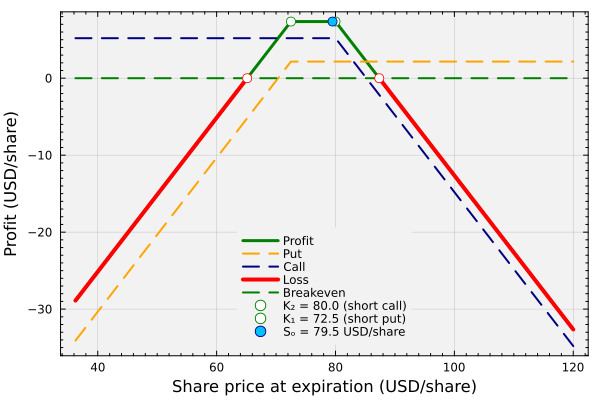

In [31]:
let

    K₁ =  put_leg_data[:Strike];
    K₂ = call_leg_data[:Strike];
    premium_1 = put_leg_data[:Mid]
    premium_2 = call_leg_data[:Mid]
    max_profit = (premium_1 + premium_2);
    
    S = share_price_array
    number_of_steps = length(S);
    BEL = zeros(length(S))

    profit_idx = findall(>(0), profit_array[:,4])
    loss_array = profit_array[:,:]; loss_array[profit_idx,:] .= NaN
    
    breakeven_array = zeros(2,2);
    breakeven_array[1,1] = K₂ + (premium_1 + premium_2);
    breakeven_array[2,1] = K₁ - (premium_1 + premium_2);

    
    plot(profit_array[:,1], profit_array[:,4], lw=3, label="Profit", c=:green, 
        bg="gray95", 	background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:bottom, 
        xminorticks=10, yminorticks=10)
    plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Put", ls=:dash, c=:orange)
    plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Call", ls=:dash, c=:navyblue)
    plot!(loss_array[:,1], loss_array[:,4], lw=4, label="Loss", c=:red)
    
    plot!(S,BEL,lw=2, c=:green, label="Breakeven", ls=:dash)
    scatter!(breakeven_array[:,1], breakeven_array[:,2], c=:white, msc=:red,label="", ms=5)
    
    scatter!([K₂],[max_profit], ms=5, label = "K₂ = $(K₂) (short call)", msc=:green, c=:white)
    scatter!([K₁],[max_profit], ms=5, label = "K₁ = $(K₁) (short put)", msc=:green, c=:white)

    
    # VLINE[1] = Sₒ
    # VLINE[2] .= range(minimum(-1*profit_array[:,end]), stop = maximum(profit_array[:,end]), length = number_of_steps) |> collect;
    scatter!([Sₒ], [max_profit], ms=5, c=:deepskyblue1, msc=:navy, ls=:dash, label="Sₒ = $(Sₒ) USD/share")
    
    xlabel!("Share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit (USD/share)", fontsize=18)
end

In [32]:
do_I_see_the_profit_loss_plot = true; # set this value {true | false}

### Breakeven analysis
Compute the breakeven points for the short `MU` straddle. Save these values in the `B_low::Float64` and `B_high::Float64` variables. A strangle has two possible breakeven points at expiration denoted as $B^{+}$ and $B^{-}$:
$$
\begin{equation}
	B(T) = \begin{cases}
		B^{-} = K_{1} - \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right) & S_{T} < K_{1} \\
		B^{+} = K_{2} + \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right) & S_{T} > K_{2}
	\end{cases}
\end{equation}
$$
where $S_{T}$ denotes the share price at expiration, $B^{+}$ denotes the upper breakeven point, $B^{-}$ denotes the lower breakeven point, index $j=1$ denotes the $\texttt{put}$ contract, $j=2$ denote the $\texttt{call}$ contract; for a strangle $K_{1}<K_{2}$. 

In [33]:
B_low, B_high = let

    # initialize -
    B_low = nothing;
    B_high = nothing;

    # Low - put side
    K₁ = put_contract_model.K; # TODO: update me with the put data
    P₁ = put_contract_model.premium; # TODO: update me with the put data

    # High - call side
    K₂ = call_contract_model.K; # TODO: update me with the call data
    P₂ = call_contract_model.premium; # TODO: update me with the call data

    # compute -
    B_low = K₁ - (P₁ + P₂);
    B_high = K₂ + (P₁ + P₂);

    # return -
    B_low, B_high
end;

In [34]:
println("Breakeven downside = $(B_low) USD/share and Breakeven upside = $(B_high) USD/share")

Breakeven downside = 65.14 USD/share and Breakeven upside = 87.36 USD/share


## Task 3: Compute the probability of profit for the random short strangle
In this task, we'll compute the likelihood of various profit levels for the random short-strangle position. To do this, we'll construct models that predict the underlying asset's share price to the contracts' expiration and then use the cumulative distribution function to compute the probability of various conditions being true. 

Let's start by building two models we use to estimate future share price: __Model 1__: geometric Brownian motion (GBM) and __Model 2__: Implied Volatility models.

### Model 1: Geometric Brownian Motion
Despite a few shortcomings, a nice feature of Geometric Brownian motion is that it has a convenient analytical solution:
$$
\begin{equation*}
S(t) = S_{\circ}\cdot\exp\Biggl[\left(\mu-\frac{\sigma^{2}}{2}\right)\cdot\left(t - t_{\circ}\right) + (\sigma\sqrt{t-t_{\circ}})\cdot{Z(0,1)}\Biggr]
\end{equation*}
$$
where $S_{\circ}$ is the initial share price at $t_{\circ}$, and $Z(0,1)$ is a standard normal random variable. Geometric Brownian motion will produce a future share price distribution that follows a Log Normal distribution, with expectation and variance of the form:
$$
\begin{eqnarray*}
\mathbb{E}\left(S_{t}\right) &=& S_{o}\cdot{e}^{\mu\cdot\Delta{t}}\\
\text{Var}\left(S_{t}\right) &=& S_{\circ}^{2}e^{2\mu\cdot\Delta{t}}\left[e^{\sigma^{2}{\Delta{t}}} - 1\right]
\end{eqnarray*}
$$
where $\Delta{t} = t - t_{\circ}$. We'll use the analytical solution to compute the distribution of share price values at $t = T$, i.e., at the contract's expiration.

#### Implementation
Build an instance of the [MyGeometricBrownianMotionEquityModel type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) which holds values for the drift `μ` and volatility `σ` parameters using a [custom build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}). 
* We set the drift parameter to the risk-free rate $\mu = \bar{r}$ (because options use a risk-neutral probability measure), and the volatility is set to the implied volatility estimate $\sigma = \text{IV}$ from the options chain data.
* __Hmmm__. But we have two contracts? Let's use the average `IV` value for two contracts. Alternatively, we could use the average IV value computed over all contracts. Historically, the average IV value for `MU` contracts is around 40% - 50%.

In [35]:
model, σ̄ = let

    # Step 1: compute the average implied volatility σ̄:
    σ̄ = (1/2)*(call_leg_data[:IV] + put_leg_data[:IV]);

    # Step 2: build the GBM model
    model = build(MyGeometricBrownianMotionEquityModel, (
        μ = risk_free_rate, # TODO: update me with the correct mu -
        σ = σ̄ # TODO: update me with the correct sigma
    ));

    model, σ̄
end;

Now that we have a populated [MyGeometricBrownianMotionEquityModel instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) holding the `MU` data, let's generate `number_of_samples` possible future share price values using the [sample(...) function exported by the VLQuantitativeFinancePackage.jl package](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}).
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) takes a `model::MyGeometricBrownianMotionEquityModel` instance as the first argument, along with the time values that we wish to sample: `T₁::Float64` is the start time, `T₂::Float64` is the stop-time (in units of `years`), `Δt::Float64` is the time step (in units of `years`), and `Sₒ::Float64` denotes the initial share price (in units of `USD/share`). Finally, we pass in the number of samples we want to generate in the `number_of_paths` argument.
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) generates `number_of_paths` sample paths from $T_{1}\rightarrow{T}_{2}$ in steps of $\Delta{t}$. However, we only want the share prices corresponding to the duration of the contract, i.e., $T_{2} = \text{DTE}\cdot\Delta{t}$. Thus, we pass the full `samples` array [using the Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) to a slicing operation where we select columns `2:end` of the last row (col 1 holds the time). We store the `number_of_paths` samples of the share price at $T_{2}$ in the `endpoint::Array{Float64,1}` variable.

In [36]:
endpoint = let
    number_of_samples = 10000;
    endpoint = VLQuantitativeFinancePackage.sample(model, (
        T₁ = 0.0,
        T₂ = (DTE)*(Δt),
        Δt = Δt,
        Sₒ = Sₒ
    ), number_of_paths = number_of_samples) |> samples -> samples[end,2:end]; # get last row from col 2 -> number_of_paths

    endpoint;
end;

We've previously shown that sampling a GBM model, emits a LogNormal share price distribution. Fit a [LogNormal distribution exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.LogNormal) using the [fit_mle(...) function exported by Distributions.jl](https://juliastats.org/Distributions.jl/stable/fit/#Distributions.fit_mle-Tuple{Any,%20Any}), and save this in the `d_gbm` variable:

In [37]:
d_gbm = fit_mle(LogNormal, endpoint);

### Model 2: Future share price projection using the Implied Volatility
Alternatively, we could use the implied volatility to estimate the expected share price move over some time $0\rightarrow{T}$.
Suppose we construct a [Normal distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal) $\mathcal{N}(\mu_{IV},\sigma_{IV})$ where mean $\mu_{IV} = S_{\circ}\exp(\bar{r}\cdot{T\Delta{t}})$, i.e., the risk-neutral future value of the current share price, or just $\mu_{IV}\approx{S}_{\circ}$ for short duration contracts, and standard deviation $\sigma_{IV}$ is:
$$
\sigma_{IV} = S_{\circ}\cdot\left(\frac{\text{IV}}{100}\right)\cdot\sqrt{\text{T}\cdot\Delta{t}}
$$
using the [Normal type exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal). 
* __Note__ In the expression above, the `IV` is given as a percentage `X.Y%.` If we already have a decimal, then do __not__ divided by `100.`

This is only an `approximate model` of the future share price. However, this model is widely used to generate quick estimates of future share price ranges using the forward-looking implied volatility `IV.`  Let's save the Normal IV distribution distribution $\mathcal{N}(\mu_{IV},\sigma_{IV})$ in the `d_IV` variable (don't forget to use $\bar{\sigma}$ for the implied volatility, as a decimal):

In [38]:
d_IV = Normal(Sₒ*exp(risk_free_rate*DTE*Δt), Sₒ*(σ̄)*sqrt(DTE*Δt));

`Unhide` the code block below to see how we plotted the `d_gbm` and `d_IV` future share price densities at `T = 62 days.`  
* __Summary__: The log-normal gbm share price distribution (blue line) and the normal-IV distribution (red line) are similar. However, the log-normal gbm model is right-skewed and cannot admit negative share prices. On the other hand, the normal IV distribution (red line) is more symmetric around the initial share price $S_{\circ}$ = `79.50 USD/share.`

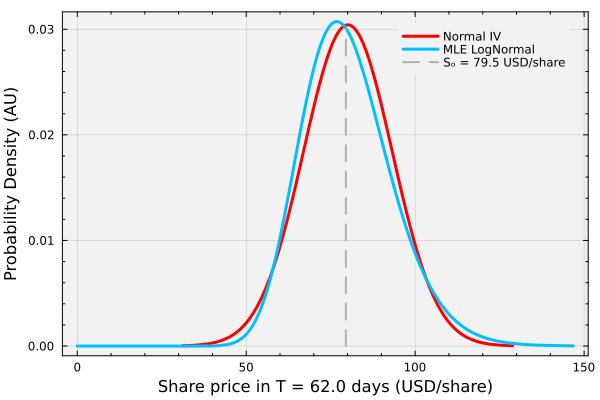

In [39]:
let
    number_of_steps = 1000;
    plot(d_IV, lw=3, label="Normal IV", c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, 
        xminorticks=5, yminorticks=5)
    plot!(d_gbm, lw=3, label="MLE LogNormal", c=:deepskyblue1)

    VLINE = zeros(number_of_steps, 2)
    VLINE[:,1] .= Sₒ*ones(number_of_steps)
    VLINE[:,2] = range(0.0,0.03,length=number_of_steps);
    plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(Sₒ) USD/share")
    
    xlabel!("Share price in T = $(DTE) days (USD/share)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
end

In [40]:
do_I_see_the_share_price_plot = true; # set this value {true | false}

### Probability of Profit at Expiration
In this step, we'll estimate [the cumulative distribution function (CDF)](https://en.wikipedia.org/wiki/Cumulative_distribution_function) for the geometric Brownian motion and implied volatility share price distributions. 
We can query the cumulative distribution function $F_{S}(\star)$ using for the projected geometric Brownian motion distribution `d_gbm` and the Implied Volatility price distribution `d_IV` using [the `cdf(...)` function exported by the Distributions.jl package](https://github.com/JuliaStats/Distributions.jl?tab=readme-ov-file).

#### Refresher on Cumulative Probability Functions
Before starting the calculations, let's quickly refresh our knowledge of what the cumulative probability distribution function tells us. The cumulative distribution function of a real-valued random variable $X$ (this is share price at expiration in our case) is given by:
$$
P(X\leq{x}) = F_{X}(x)
$$
that is, the probability that we see a value for the random variable $X$ less than or equal to the specified value $x$ is the cumulative distribution function evaluated at $x$. Alternatively, $P(X>x)$ is given by:
$$
P(X>{x}) = 1 - F_{X}(x)
$$
Lastly, the probability that $X$ (share price at expiration) lies in the interval $(a,b]$, where $a < b$ is given by:
$$
P(a < X \leq b) = F_{X}(b) - F_{X}(a)
$$
In [Julia we can use the `cdf(...)` function exported from the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.cdf-Tuple{UnivariateDistribution,%20Real}) to compute $F_{S}\left(x\right)$.

#### Visualize CDF
Let's use our `d_gbm` and `d_IV` distribution models to visualize the cumulative distribution function for share price of `MU` at contract expiration.

`Unhide` the code block below to see how we plotted the cumulative distribution function (CDF) for `MU` share price at contract expiration using the risk-neutral geometric Brownian motion `d_gbm` and IV-based price distributions `d_IV.` 

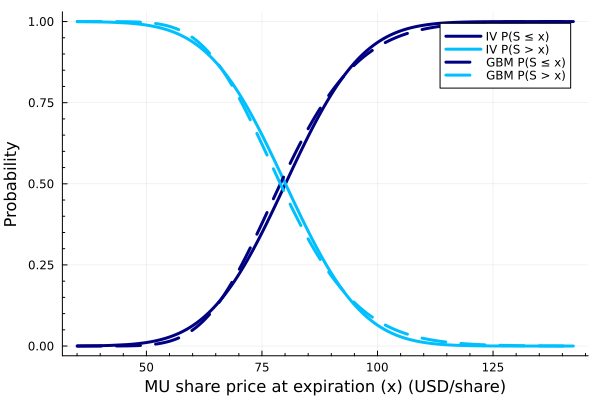

In [41]:
X = let
    number_of_samples = length(endpoint);
    X = Array{Float64,2}(undef, number_of_samples, 3);
    S = Array{Float64,1}();
    for i ∈ eachindex(endpoint)
        push!(S,endpoint[i]);
    end
    S = sort(S);
    
    for i ∈ eachindex(S)
    
        X[i,1] = S[i];
        X[i,2] = cdf(d_gbm, S[i]);
        X[i,3] = cdf(d_IV, S[i]);
    end

    plot(X[:,1], X[:,3], lw=3, c=:navy, label="IV P(S ≤ x)", xminorticks=5, yminorticks=5)
    plot!(X[:,1], 1 .- X[:,3], lw=3, c=:deepskyblue1, label="IV P(S > x)")

    plot!(X[:,1], X[:,2], lw=3, c=:navy, label="GBM P(S ≤ x)", xminorticks=5, yminorticks=5, ls=:dash)
    plot!(X[:,1], 1 .- X[:,2], lw=3, c=:deepskyblue1, label="GBM P(S > x)", ls=:dash)

    xlabel!("MU share price at expiration (x) (USD/share)", fontsize=18);
    ylabel!("Probability", fontsize=18);
end

In [42]:
do_I_see_the_CDF_plot = true; # set this value {true | false}

In [43]:
B_low, B_high = let

    # initialize -
    B_low, B_high = 0.0, 0.0; # set breakevens to zero

    # Step 1: get short put contract data (index 1)
    K₁ = put_contract_model.K;
    P₁ = put_contract_model.premium;

    # Step 2: get short call contract data (index 2)
    K₂ = call_contract_model.K;
    P₂ = call_contract_model.premium;

    # Step 3: compute the breakeven prices 
    B_low = K₁ - (P₁ + P₂); # break-even on put side
    B_high = K₂ + (P₁ + P₂); # break-even on call side

    # return
    B_low, B_high
end;

In [44]:
println("The low breakeven = $(B_low) USD/share with the high breakeven = $(B_high) USD/share")

The low breakeven = 65.14 USD/share with the high breakeven = 87.36 USD/share


From the CDF curves, what is the (approximate) probability that `MU` shares will close _below_ `90 USD/share` at expiration (use the GBM curve)?

In [59]:
estimated_probability_of_90_USD_per_share_at_expiration = 0.70; # fill in an estimate

### Probability of Various Outcomes
Now that we have our cumulative distributions, we can compute the probability of observing various scenarios. Let's consider three scenarios.

__Scenario 1: Downside loss__. In this scenario, the share price at expiration $S_{T}$ is at least $\epsilon$ _below_ the downside breakeven point $B^{-}$, assuming $\epsilon \geq $ `0.01` USD/share. The probability of this scenario occurring is given by $P(S_{T}\leq{B^{-}} - \epsilon) = F_{S}\left(B^{-} - \epsilon\right)$.

In [96]:
p_downside_loss_gbm, p_downside_loss_IV = let

    # initialize 
    ϵ = 0.01; # 1/100 USD
    p_downside_loss_gbm = nothing;
    p_downside_loss_IV = nothing;

    # compute P(S < B_low -  ϵ) for the GBM and IV models
    p_downside_loss_gbm = cdf(d_gbm,B_low-ϵ); # TODO: update me
    p_downside_loss_IV = cdf(d_IV,B_low-ϵ) # TODO update me

    # return data -
    p_downside_loss_gbm, p_downside_loss_IV
end

(0.12349585844976335, 0.12708334785809083)

In [97]:
println("Scenario 1: Probability (GBM,IV) = ($(p_downside_loss_gbm),$(p_downside_loss_IV))")

Scenario 1: Probability (GBM,IV) = (0.12349585844976335,0.12708334785809083)


__Scenario 2: Upside loss__. In this scenario, the share price at expiration $S_{T}$ is at least $\epsilon$ _above_ the upside breakeven point $B^{+}$, assuming $\epsilon \geq $ `0.01` USD/share. The probability of this scenario occurring is given by $P(S_{T}>B^{+} + \epsilon) = 1 - F_{S}\left(B^{+} + \epsilon\right)$.

In [108]:
p_upside_loss_gbm, p_upside_loss_IV = let

    # initialize 
    ϵ = 0.01; # 1/100 USD
    p_upside_loss_gbm = nothing;
    p_upside_loss_IV = nothing;

    # compute P(S > B_low +  ϵ) for the GBM and IV models
    p_upside_loss_gbm = 1 - cdf(d_gbm,B_high+ϵ); # TODO: update me
    p_upside_loss_IV = 1 - cdf(d_IV,B_high+ϵ); # TODO: update me

    # return data -
    p_upside_loss_gbm, p_upside_loss_IV
end;

In [109]:
println("Scenario 2: Probability (GBM,IV) = ($(p_upside_loss_gbm),$(p_upside_loss_IV))")

Scenario 2: Probability (GBM,IV) = (0.27256803770598914,0.2892555754849986)


__Scenario 3: Maximum profit__. In this scenario, the share price at expiration $S_{T}$ is between the strike prices $K_{1}$ and $K_{2}$. The probability of this scenario occurring is given by $P(K_{1} < S_{T} \leq{K_{2}}) = F_{S}\left(K_{2}\right) - F_{S}\left(K_{1} + \epsilon\right)$, assuming $\epsilon \geq $ `0.01` USD/share.

In [110]:
p_max_profit_gbm, p_max_profit_IV = let

    # initialize 
    ϵ = 0.01; # 1/100 USD
    p_max_profit_gbm = nothing;
    p_max_profit_IV = nothing;

    # compute the probability P(S_low < S_{T} ≤ S_high) for the GBM and IV
    p_max_profit_gbm = cdf(d_gbm,B_high) - cdf(d_gbm,B_low+ϵ); # TODO update me
    p_max_profit_IV = cdf(d_IV,B_high) - cdf(d_IV,B_low+ϵ); # TODO update me

    # return data -
    p_max_profit_gbm, p_max_profit_IV
end;

In [111]:
println("Scenario 3: Probability (GBM,IV) = ($(p_max_profit_gbm),$(p_max_profit_IV))")

Scenario 3: Probability (GBM,IV) = (0.6033314278760744,0.5830824714333542)


#### Probability of profit (POP) table
`Unhide` the code block below to see how we developed a table displaying the probability of profit calculations for an `MU` put option using the risk-neutral geometric Brownian motion `d_gbm` and IV-based price distributions `d_IV.` 
* __Summary__: For each random combination of `MU` call and put contracts, the maximum profit and the probability of the various outcomes will change. However, if you rerun the notebook a few times, some interesting patterns emerge. 

In [112]:
let 
    
    table_df = DataFrame()
    ϵ = 0.01;

    # GBM row -
    gbm_row = (
        model="GBM",
        Sₒ = Sₒ,
        DTE = DTE,
        put_K₁ = put_contract_model.K,
        call_K₂ = call_contract_model.K,
        max_profit = (call_contract_model.premium + put_contract_model.premium),
        p_max_profit = p_max_profit_gbm,
        p_downside_loss = p_downside_loss_gbm,
        p_upside_loss = p_upside_loss_gbm,
    );
    push!(table_df, gbm_row);

    # IV row -
    IV_row = (
        model="IV",
        Sₒ = Sₒ,
        DTE = DTE,
        put_K₁ = put_contract_model.K,
        call_K₂ = call_contract_model.K,
        max_profit = (call_contract_model.premium + put_contract_model.premium),
        p_max_profit = p_max_profit_IV,
        p_downside_loss = p_downside_loss_IV,
        p_upside_loss = p_upside_loss_IV,
    );
    push!(table_df, IV_row);
    
    # make a table -
    pretty_table(table_df)
end

┌────────┬─────────┬─────────┬─────────┬─────────┬────────────┬──────────────┬─────────────────┬───────────────┐
│  model │      Sₒ │     DTE │  put_K₁ │ call_K₂ │ max_profit │ p_max_profit │ p_downside_loss │ p_upside_loss │
│ String │ Float64 │ Float64 │ Float64 │ Float64 │    Float64 │      Float64 │         Float64 │       Float64 │
├────────┼─────────┼─────────┼─────────┼─────────┼────────────┼──────────────┼─────────────────┼───────────────┤
│    GBM │    79.5 │    62.0 │    72.5 │    80.0 │       7.36 │     0.603331 │        0.123496 │      0.272568 │
│     IV │    79.5 │    62.0 │    72.5 │    80.0 │       7.36 │     0.583082 │        0.127083 │      0.289256 │
└────────┴─────────┴─────────┴─────────┴─────────┴────────────┴──────────────┴─────────────────┴───────────────┘


In [113]:
do_I_see_the_POP_table = true; # set this value {true | false}

### Discussion questions
1. What directional relationship `{direct | inverse}` between maximum profit and the probability of max profit do you observe (run a few times, collect the data)? Why would you expect the pattern that you observed?
2. A [tastylive](https://www.tastylive.com/) rule of thumb is to place the strikes such that you collect `1/3` the width of the strikes in premium. Do you see anything close to this rule of thumb in your `MU` data? If so, what are the $\Delta$ of the legs?

In [ ]:
# I would say I see a indirect relationship between maximum profit and probability of max profit with max profit being constant across the two models and the predicted changing and I would expect this pattern due to the market penetration
#and market constraints become factors in larger markets. Which targets the predicted profit as it slows it down from its initial trend upwards, there could also be varying assumptions about market volatility
#risk free rate or price dynaamics. 

#2. I would say that it is not observed at 7.36 is not a third it should be 2.5. The deltas of the legs would be -0.119 for k1 and 0.494 for k2 so 49.4% chance of being in the money.

## Tests
In the code block below, we check some values in your notebook and give you feedback on which items are correct or different. `Unhide` the code block below (if you are curious) about how we implemented the tests and what we are testing.

In [114]:
let 
    @testset verbose = true "CHEME 5660 problem set 5 test suite" begin

        @testset "Task 1: Call and Put contract data" begin
            @test isempty(put_contracts) == false
            @test isempty(call_contracts) == false
            @test length(call_leg_data) == 11
            @test length(put_leg_data) == 11
        end

        @testset "Task 2: Build Contract models, profit diagram and breakeven" begin
            @test typeof(put_contract_model) == MyAmericanPutContractModel 
            @test typeof(call_contract_model) == MyAmericanCallContractModel
            @test isempty(profit_array) == false
            @test isa(B_low, Number) == true
            @test isa(B_high,Number) == true
            @test do_I_see_the_profit_loss_plot == true
        end

        @testset "Task 3: POP calculations" begin
            @test typeof(model) == MyGeometricBrownianMotionEquityModel
            @test isa(σ̄, Number) == true
            @test (σ̄ > 0) == true
            @test isempty(endpoint) == false
            @test do_I_see_the_share_price_plot == true
            @test do_I_see_the_CDF_plot == true
            @test isapprox(estimated_probability_of_90_USD_per_share_at_expiration,0.70) == true
            @test isempty(X) == false
            @test do_I_see_the_POP_table == true
            @test isa(p_downside_loss_gbm,Number) == true
            @test isa(p_downside_loss_IV,Number) == true
            @test isa(p_upside_loss_gbm,Number) == true
            @test isa(p_upside_loss_IV,Number) == true
            @test isa(p_max_profit_gbm,Number) == true
            @test isa(p_max_profit_IV,Number) == true
        end 
    end
end;

Test Summary:                                                 | Pass  Total  Time
CHEME 5660 problem set 5 test suite                           |   25     25  0.0s
  Task 1: Call and Put contract data                          |    4      4  0.0s
  Task 2: Build Contract models, profit diagram and breakeven |    6      6  0.0s
  Task 3: POP calculations                                    |   15     15  0.0s


## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.